# SIT319/SIT744 Assignment 1

## **Group 1 (P Tasks) Construct a forward neural network**

*(weight ~60%)*

With this group of tasks, you are going to build a neural network for the image classification task. You will train the model on the [diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset).

#### Importing Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
%matplotlib inline
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization , Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from copy import deepcopy
import torch.utils.data
from torch.optim import SGD

import warnings
warnings.filterwarnings("ignore")

###### 1. Describe the target classes for the prediction task. Display 10 training examples from each target class. Do you see any patterns?

In [2]:
dataset_path = 'E:\T2 2023\SIT744 DL\Assignments\diabetes_prediction_dataset.csv'
df = pd.read_csv(dataset_path)
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


- For the diabetes dataset , the target variable is "diabetes," which appears to be a binary variable indicating the presence or absence of diabetes for each individual. It is likely that the value 1 represents the presence of diabetes, and 0 represents the absence of diabetes.

In [3]:
print("Examples with diabetes (target = 1):")
df[df['diabetes'] == 1].head(10)

Examples with diabetes (target = 1):


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
6,Female,44.0,0,0,never,19.31,6.5,200,1
26,Male,67.0,0,1,not current,27.32,6.5,200,1
38,Male,50.0,1,0,current,27.32,5.7,260,1
40,Male,73.0,0,0,former,25.91,9.0,160,1
53,Female,53.0,0,0,former,27.32,7.0,159,1
55,Male,50.0,0,0,former,37.16,9.0,159,1
59,Female,67.0,0,0,never,63.48,8.8,155,1
81,Male,57.0,0,0,No Info,27.32,8.2,126,1
87,Female,36.0,0,0,current,32.27,6.2,220,1
94,Female,60.0,0,0,never,27.32,7.5,300,1


In [4]:
print("\nExamples without diabetes (target = 0):")
df[df['diabetes'] == 0].head(10)


Examples without diabetes (target = 0):


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0
10,Female,53.0,0,0,never,27.32,6.1,85,0


- The observed patterns indicate that elevated HbA1c levels, increased blood glucose levels, higher BMI values, and older age are linked to a higher probability of diabetes. In contrast, lower HbA1c levels, reduced blood glucose levels, lower BMI values, and younger age are correlated with a decreased likelihood of diabetes.

##### 2. Describe the data types of each feature. What preprocessing steps are required? Why?

In [5]:
print(df.dtypes)

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


**Based on the given data, the data types of each feature are as follows:**

1. Gender: Categorical (object)
    - Represents the gender of the individual (e.g., Male or Female).

2. Age: Numerical (float64)

    - Represents the age of the individual in years.

3. Hypertension: Binary (int64)

    - Indicates whether the individual has hypertension or not (0 for no, 1 for yes).
    - It is a binary variable used as a label for classification tasks.

4. Heart_Disease: Binary (int64)

    - Indicates whether the individual has a heart disease or not (0 for no, 1 for yes).
    - It is a binary variable used as a label for classification tasks.

5. Smoking_History: Categorical (object)

    - Represents the smoking history of the individual (e.g., never, former, current, No Info).

6. BMI: Numerical (float64)

    - Represents the Body Mass Index (BMI) of the individual.

7. HbA1c_Level: Numerical (float64)

    - Represents the HbA1c level of the individual, which is a measure of average blood sugar levels over the past 2 to 3 months.

8. Blood_Glucose_Level: Numerical (int64)

    - Represents the blood glucose level of the individual.

9. Diabetes: Binary (int64)

    - Indicates whether the individual has diabetes or not (0 for no, 1 for yes).
    - It is the target variable for the classification task.

###### Pre-Processing

**a. To check for null values**

In [6]:
if df.isnull().sum().all() == 0:
    print("There are no null values in the whole dataset.")
else:
    print("There are null values in the dataset.")

There are no null values in the whole dataset.


- Checking and handling missing values during pre-processing is essential for ensuring the accuracy, reliability, and integrity of the data used for analysis and modeling.
- In our case, there were no missing values in the dataset

**b. One-hot encode categorical variables: 'gender' and 'smoking_history'**

In [7]:
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
df.head(5)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,1,0,0,0,0


- Neural networks operate on numerical data and mathematical operations. One-hot encoding allows us to represent categorical variables as binary vectors, ensuring compatibility with the numeric computations performed within the neural network.
- In the example, we are turning the 'gender' and 'smoking_history' columns of the df dataframe into numerical values.

**c. Standardize numeric features**

In [8]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

- For the specific case of the features mentioned (Age, BMI, HbA1c_Level, and Blood_Glucose_Level), they may have different ranges and units. By scaling them to a similar range using StandardScaler(), we ensure that all features contribute equally to the neural network training process, resulting in a more effective and stable learning process.

##### 3. Prepare the data for learning a neural network, including creating training, validation, and test datasets. How many training examples and how many test examples are you using?

In [9]:
# Extract features and target variable
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Check the number of training and test examples
num_train_examples = X_train.shape[0]
num_val_examples = X_val.shape[0]
num_test_examples = X_test.shape[0]

print("Number of training examples:", num_train_examples)
print("Number of Validation examples:", num_val_examples)
print("Number of test examples:", num_test_examples)

Number of training examples: 80000
Number of Validation examples: 10000
Number of test examples: 10000


### Task 1.2 Setting up a model for training

(weight ~ 20%)

In [10]:
# Construct a deep feedforward neural network

model = Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    layers.Dense(16, activation='relu'),  # Second hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer
])

In [11]:
# Print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 993 (3.88 KB)
Trainable params: 993 (3.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


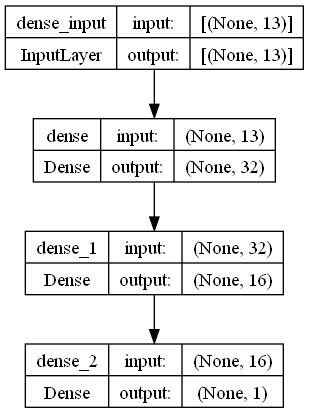

In [12]:
# Plot the model structure
plot_model(model, show_shapes=True)

In [13]:
X_train.shape

(80000, 13)

**Output layer:**
1. How many output nodes?
    - Number of output nodes: The output layer has 1 node, as we are performing binary classification (predicting whether an individual has diabetes or not).
    
2. Which activation function?
    - Activation function: The output layer uses the sigmoid activation function. It squashes the output between 0 and 1, representing the probability of the positive class (diabetes present).

**Hidden layers:**
1. How many hidden layers?

    - There are 2 hidden layers in the neural network.
---
    
2. How many nodes in each layer?

    - The first hidden layer has 32 nodes, and the second hidden layer has 16 nodes.
---
    
3. Which activation function for each layer?

    - Both hidden layers utilize the ReLU (Rectified Linear Unit) Activation Function, which effectively transforms linear combinations of inputs into non-linear outputs, allowing the neural network to capture more intricate relationships within the data.
    
---


**Input layer:**
    
1. What is the input size?

    - The input size is 13. The layer receives as input a shape tensor (xtrain.shape[1],), which corresponds to the format of the input data of the training set.
   
---
    
2. Do you need to reshape the input? Why?

    - In this case, the input data has 80000 samples and 13 features for each sample. As the input shape is (80000, 13), there is no need to reshape the input. Reshaping the input data typically becomes necessary when the input data is in a format that doesn't match the expected input shape of the model.

---

### Task 1.3 Fitting the model

**The loss function**

- In our case, we have a binary classification problem with two classes (diabetes or no diabetes), so "Binary Crossentropy" is the appropriate loss function.
- The loss function is used to guide the model during training by minimizing the error between the predicted values and the true labels. Binary crossentropy is well-suited for binary classification tasks.

---

**The metrics for model evaluation (which may be different from the loss function)**

- For model evaluation, we will utilize accuracy as the metric. Accuracy quantifies the proportion of correctly predicted instances out of the total instances, offering a comprehensive measure of the model's ability to predict the correct class.
---

**Optimizer**

- We will use the Adam optimizer, which is an adaptive learning rate optimization algorithm. Adam combines the benefits of RMSprop and momentum, making it effective for our neural network.
---


In [14]:
#Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**The training batch size**

- In this case, a batch size of 32 has been used, which means that the model will process 32 training examples at a time during each iteration. After processing each batch of 32 examples, the model's weights will be updated based on the calculated gradients.
---

**The number of training epochs**

- The number of epochs specifies how many times the model will be trained on the complete dataset. In this case, we will use 50 epochs, enabling the model to undergo numerous training iterations to grasp intricate patterns within the data.
---

**The learning rate. If you used momentum or a learning rate schedule, please report the configuration as well**

- We have used the Learning Rate Scheduler callback to find the final learning rate which was found to be 0.00177. In this configuration, we have set up the LearningRateScheduler callback to adjust the learning rate during training. 
- The learning rate will be increased by a small factor of 1.1 at each epoch with batch_size=32, epochs=50, allowing the model to potentially find a more optimal learning rate during training.

---


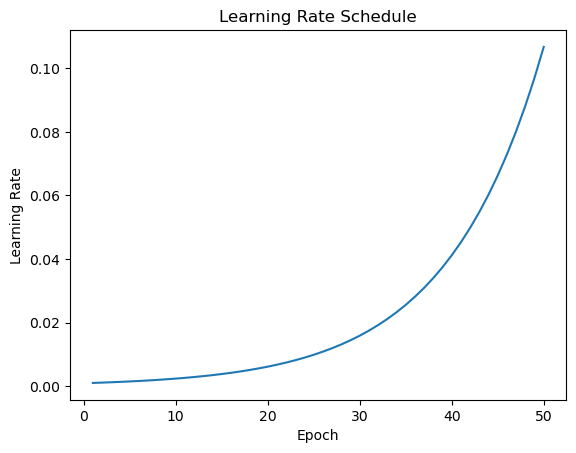

In [15]:
# Define the learning rate scheduler callback
def lr_scheduler(epoch, lr):
    return lr * 1.1  # Increase the learning rate by a small factor at each epoch

# Create the learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Compile the model with a high initial learning rate (e.g., 0.001)
# This high initial learning rate will be adjusted by the learning rate scheduler callback during training
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the training data with the learning rate scheduler callback
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[lr_scheduler_callback], verbose=0)

# Plot the learning rate schedule
learning_rates = [0.001 * (1.1 ** epoch) for epoch in range(50)]
plt.plot(range(1, 51), learning_rates)
plt.xlabel('Epoch') 
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

In [16]:
# Find the optimal learning rate based on the loss curve
min_val_loss_idx = np.argmin(history.history['val_loss'])
optimal_lr = learning_rates[min_val_loss_idx]
print(f"Optimal learning rate: {optimal_lr}")

Optimal learning rate: 0.001771561000000001


##### Now fit the model. Show how the training loss and the evaluation metric change. How did you decide when to stop training?

---
- The EarlyStopping callback is a useful tool for preventing overfitting and finding the optimal number of epochs automatically.
- The patience was set to 5, which means that if the validation loss does not improve for 5 consecutive epochs, the training will stop. 
- Stopping at 7 epochs indicates that the model's performance on the validation set did not improve significantly after that point, and further training would likely not yield better results. As a result, EarlyStopping prevented the model from overfitting and saved computation time.
---

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Fit the model to the training data with the early stopping callback
# We are allowing the training logs to be displayed as we need to find the Epoch

history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[lr_scheduler_callback,
                                                                                                           early_stopping] )

Epoch 1/30
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1554 - accuracy: 0.9611 - val_loss: 0.1521 - val_accuracy: 0.9549 - lr: 0.1291
Epoch 2/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.1279 - accuracy: 0.9638 - val_loss: 0.1273 - val_accuracy: 0.9628 - lr: 0.1420
Epoch 3/30
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1565 - accuracy: 0.9533 - val_loss: 0.1709 - val_accuracy: 0.9429 - lr: 0.1562
Epoch 4/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.1879 - accuracy: 0.9498 - val_loss: 0.1583 - val_accuracy: 0.9549 - lr: 0.1719
Epoch 5/30
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2118 - accuracy: 0.9509 - val_loss: 0.1644 - val_accuracy: 0.9522 - lr: 0.1891
Epoch 6/30
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1671 - accuracy: 0.9585 - val_loss: 0.1643 - val_accuracy: 0.9561 - lr: 0.2080
Epoch 7/30
2500/2500 [==============================] - 4s

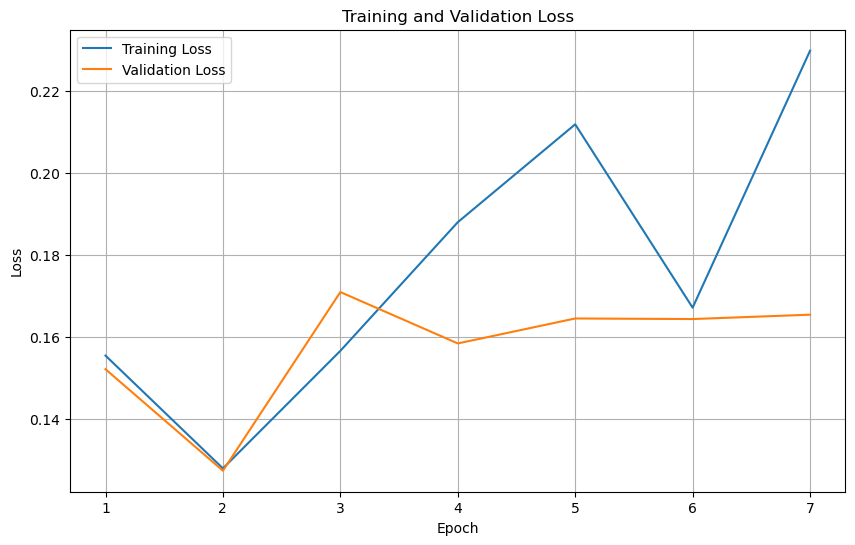

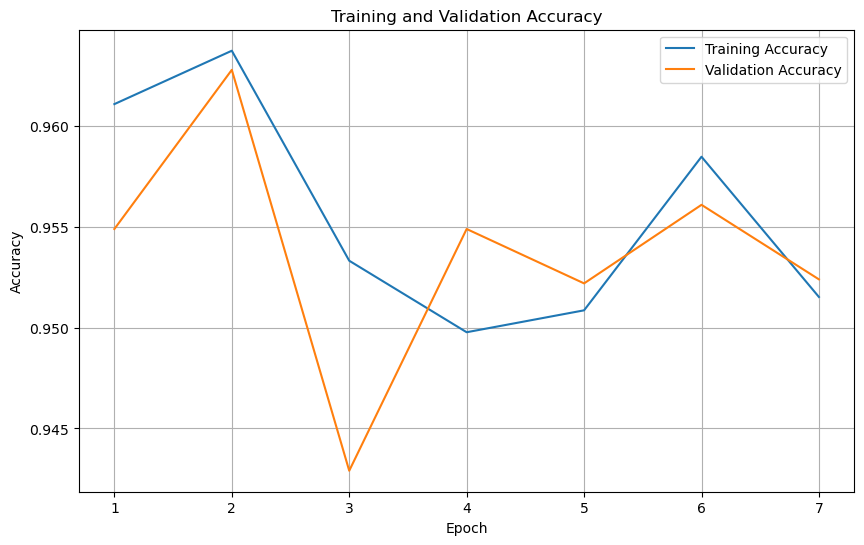

In [18]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Model Evaluation**

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 0s 1ms/step - loss: 0.1246 - accuracy: 0.9639
Test Loss: 0.124637171626091
Test Accuracy: 0.9639000296592712


**Observation**

---
- By utilizing both the learning rate scheduler and early stopping callbacks, we can dynamically adjust the learning rate during training while also ensuring that the training process halts when the model exhibits signs of overfitting, as indicated by a decline in performance on the validation set. 
- This combined approach allows for fine-tuning the learning rate and prevents the model from overfitting to the training data.
---

## **Group 2 (C Tasks) Improve the model**

(weight ~ 10%)

### Task 2.1 Check the training using TensorBoard

Use TensorBoard to visualise the training process. Show screenshots of your TensorBoard output.

Do you see overfitting or underfitting? Why?
If you see overfitting, at which epoch did it happen?


### Task 2.2 Apply regularisation

Improve the training process by applying regularisation. Below are some options:

1.   Dropout
2.   Batch normalisation

Compare the effect of different regularisation techniques on model training. You may also try other techniques for improving training such as learning rate scheduling (see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule).



### Task 2.1 Check the training using TensorBoard

In [20]:
from datetime import datetime
import os
from tensorflow.keras.callbacks import TensorBoard


root_logdir = "logs"
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(root_logdir, run_id)

# Create a TensorBoard callback
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=1
    )
]

#Fit the model
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[callbacks] , verbose=0)

In [22]:
%reload_ext tensorboard
%tensorboard --logdir=logs --port=6005

![Epoch Accuracy](Picture1.png)

![Epoch Loss](Picture2.png)

---

**The tensorboard graphs provided above for epoch loss and epoch accuracy suggest a noticeable occurrence of overfitting in the model, particularly around epoch 6 and 7.**

---

### Task 2.2 Apply regularisation

#### 1. First lets try Batch normalization method

In [25]:
# Building the model with Batch Normalization

model_batch = Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),  # Batch normalization after the first hidden layer
    layers.Dense(16, activation='relu'),  
    BatchNormalization(),  # Batch normalization after the second hidden layer
    layers.Dense(1, activation='sigmoid')  
])

In [26]:
#Compiling the model
model_batch.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Fitting the NN model
history = model_batch.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val) , verbose=0)

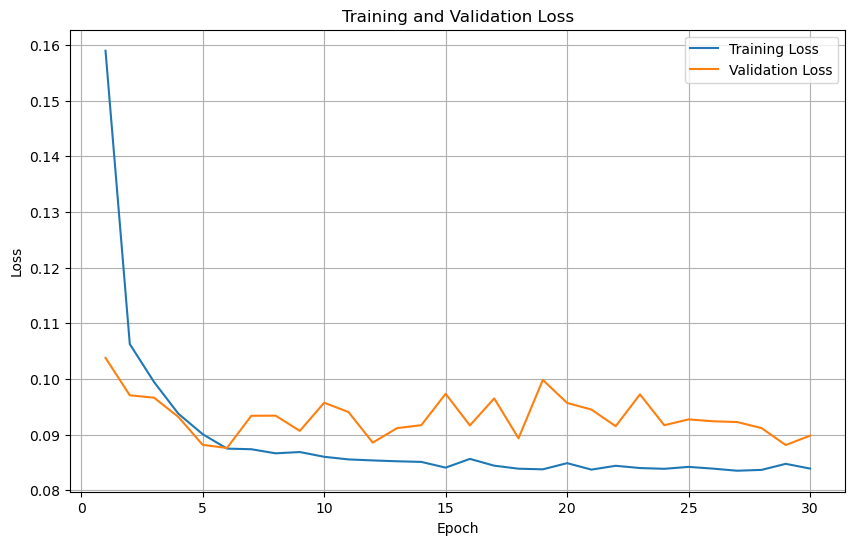

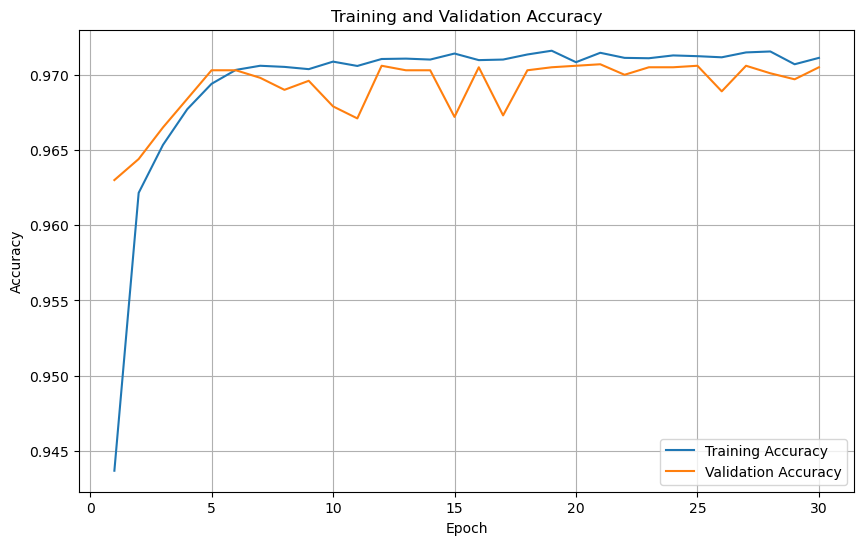

In [28]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Evaluation of the Batch normalization method on NN

test_loss, test_accuracy = model_batch.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 0s 1ms/step - loss: 0.0797 - accuracy: 0.9737
Test Loss: 0.07967396080493927
Test Accuracy: 0.9736999869346619


#### 2. Dropout Method

In [60]:
# Building the model with Batch Normalization

model_dropout = Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  
    Dropout(0.1),               # Dropout Layer 1
    layers.Dense(16, activation='relu'),  
    Dropout(0.5),               # Dropout Layer 2            
    layers.Dense(1, activation='sigmoid')  
])

In [61]:
#Compiling the model
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
history = model_dropout.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val) , verbose=0)

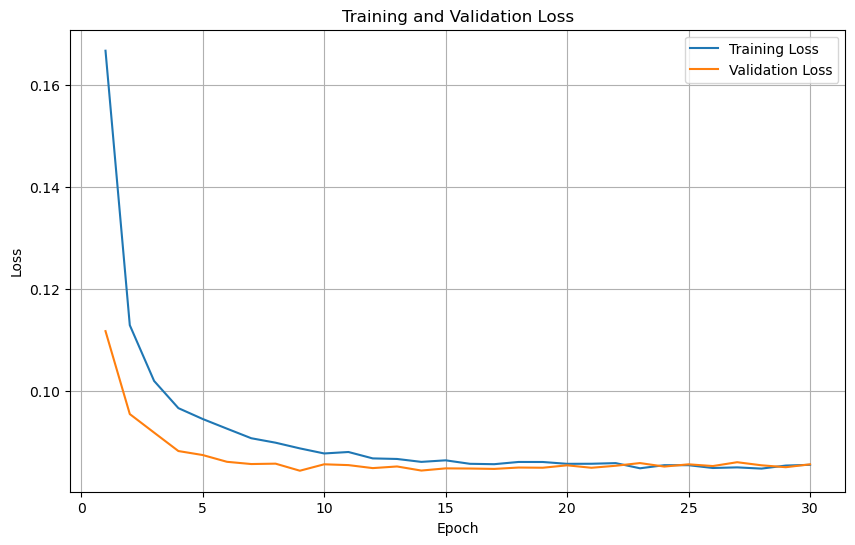

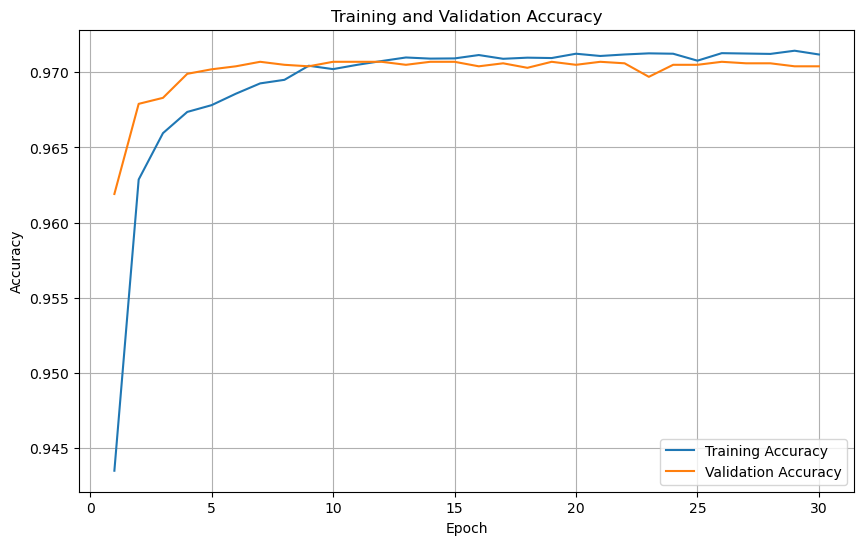

In [63]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
# Evaluation of the Drop Out method on NN

test_loss, test_accuracy = model_dropout.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 0s 1ms/step - loss: 0.0773 - accuracy: 0.9733
Test Loss: 0.07725841552019119
Test Accuracy: 0.9732999801635742


##### Observation

---

- Batch Normalization Effect: Introducing batch normalization has a positive impact on model performance compared to the baseline model without any regularization. The model's test loss decreases from 0.126 to 0.080, indicating that batch normalization aids in controlling overfitting and enhancing generalization. The test accuracy also improves significantly, increasing from 0.963 to 0.974.

- Dropout's Impact: Utilizing dropout as a regularization technique also yields improvements in test performance. The model's test loss is further reduced to 0.077, and the test accuracy remains at a high level of 0.973. This outcome demonstrates dropout's effectiveness in preventing overfitting and promoting better generalization.

---

## **Group 3 (D Tasks) Analyse the learned representations**


##### 1. Select a subset of your training data containing both classes.

In [65]:
subset_indices = np.where((y_train == 0) | (y_train == 1))[0]
X_subset = X_train.iloc[subset_indices] 
y_subset = y_train.iloc[subset_indices]

In [66]:
# Treating the Imbalanced dataset

class_counts = y_subset.value_counts()

# Determine the minority and majority class labels
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

# Find the indices of the majority and minority class
minority_indices = y_subset[y_subset == minority_class].index
majority_indices = y_subset[y_subset == majority_class].index

# Downsample the majority class to match the size of the minority class
majority_downsampled_indices = np.random.choice(majority_indices, size=len(minority_indices), replace=False)

# Combine the indices of the minority class and the downsampled majority class
balanced_indices = np.concatenate((minority_indices, majority_downsampled_indices))

# Create the balanced subset of the dataset
X_train_balanced = X_subset.loc[balanced_indices]
y_train_balanced = y_subset.loc[balanced_indices]

##### 2. Extract the embeddings from each layer of the neural network model for the dataset.

In [67]:
from tensorflow.keras import layers, models

model_embedding = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    Dropout(0.1),
    layers.Dense(16, activation='relu'),
    Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [68]:
layers_to_analyze = [0, 1, 2, 3, 4]
layer_names = ['Hidden Dense Layer 1', 'Dropout Layer 1', 'Hidden Dense Layer 2', 'Dropout Layer 2', 'Hidden Dense Layer 3']

##### 3. Apply UMAP to visualise the embeddings from each layer in a 2-dimensional space, highlighting different classes with distinct colours or markers. Include appropriate labels and legends in your plots.

425/425 [==============================] - 0s 915us/step


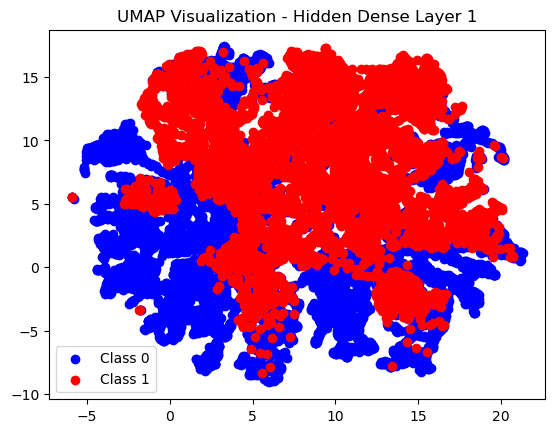

425/425 [==============================] - 0s 922us/step


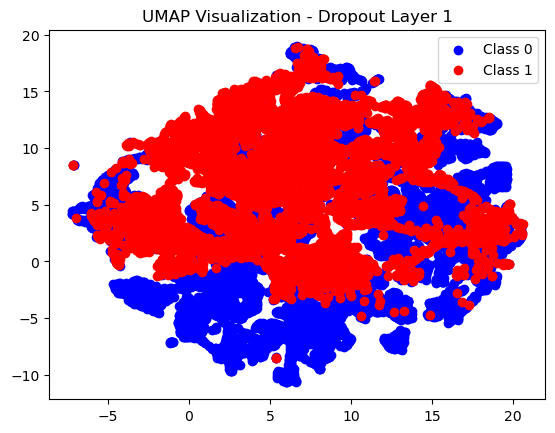

425/425 [==============================] - 0s 899us/step


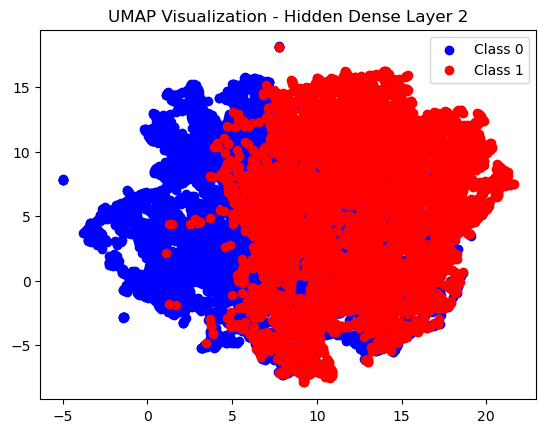

425/425 [==============================] - 0s 903us/step


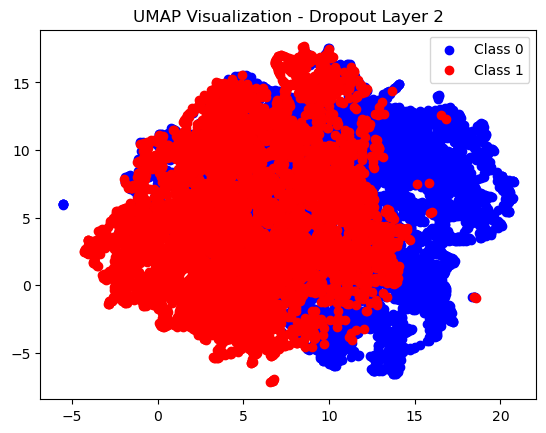

425/425 [==============================] - 1s 1ms/step


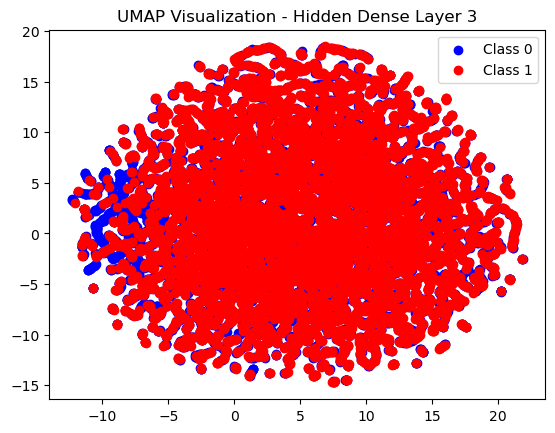

In [69]:
for layer_idx in layers_to_analyze:
    intermediate_layer_model = models.Model(inputs=model_embedding.input,
                                            outputs=model_embedding.layers[layer_idx].output)
    embeddings = intermediate_layer_model.predict(X_train_balanced)
    umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.5, metric='euclidean').fit_transform(embeddings)
    
    plt.scatter(umap_embeddings[y_train_balanced == 0, 0], umap_embeddings[y_train_balanced == 0, 1], marker='o', color='blue', label='Class 0')
    plt.scatter(umap_embeddings[y_train_balanced == 1, 0], umap_embeddings[y_train_balanced == 1, 1], marker='o', color='red', label='Class 1')
    plt.title(f'UMAP Visualization - {layer_names[layer_idx]}')
    plt.legend()
    plt.show()

##### 4. Analyse and discuss the evolution of the embeddings across layers. Answer the following questions in your analysis:


**a. Do the embeddings show a clear separation between classes at any specific layer?**
- For the First and the second hidden layer, along with both dropout layers, we can see a clear separation between the classes. 

- This suggests that the network's hierarchical features and regularization mechanisms are effectively contributing to class separation, making it easier to distinguish between different classes in the UMAP visualization.

---

**b. How do the separation and clustering of classes change as you move across layers?**

- The enhanced class separation in the second hidden layer, as we progress through the network layers, is attributed to deeper network architecture. Increased depth enables capturing intricate features and hierarchical structures from input data. 

- These deeper representations, holding more meaningful patterns and relationships, improve UMAP's ability to segregate and cluster data in lower dimensions. 

---

**c. Are there any notable changes in the distribution or structure of the embeddings?**

- We can see changes in the distribution and structure of the embeddings as we move across the layers.

- Hierarchical learning allows the network to transform the data into a representation that makes it easier to distinguish between different classes or categories. The network can disentangle the inherent factors of variation in the data, which can lead to clearer separations and more organized arrangements of data points in the embedding space.

---

**d. Are there any layers where the embeddings become less discriminative or more entangled?**

- In the last final layer, it is evident that the embeddings have become more entangled and exhibit reduced distinctness between them. The observed increase in entanglement and reduced separation of embeddings in the final layer can be attributed to a decrease in their discriminative power. This indicates that the embeddings in this layer are failing to adequately preserve the distinctions among various classes. One possible reason for this is that the intermediate layers preceding the final layer might not be effectively capturing features unique to each class. 

- Moreover, the heightened entanglement implies that the network's intermediate layers are amalgamating or merging features from various classes, contributing to the difficulty in discerning class boundaries. This could occur if the network learns intricate patterns that aren't specifically tied to individual classes, leading to a decline in the capacity to separate classes within the embeddings.

---

##### 5. Summarize your findings and provide insights into the behaviour of the neural network's representations at different layers. Discuss the implications of the observed changes in the embeddings for the network's ability to capture class-specific information and make predictions.

**In the analysis of the neural network's representations at different layers, several key insights emerge regarding the network's ability to capture class-specific information and make predictions.**

**a. Clear Separation between Classes:**
- In the first and second hidden layers, as well as the two dropout layers, a distinct separation between classes is evident. This signifies that the network's hierarchical features and regularization techniques are effectively contributing to the segregation of classes. This separation enhances the ability to differentiate between different classes in UMAP visualisations.

---

**b. Evolution of Separation and Clustering:**
- The second hidden layer demonstrates enhanced class separation as we progress through the network layers. This improvement is attributed to the network's increased depth, which facilitates the capture of intricate features and hierarchical structures from the input data. 
- These refined representations contain more meaningful patterns and relationships, thereby allowing UMAP to better separate and cluster data in lower dimensions. The second hidden layer showcases more pronounced class separation, leveraging the network's depth to capture informative representations that enhance the visualisation of distinct data classes through UMAP.

---

**c. Changes in Distribution and Structure:**
- The embeddings' distribution and structure change as we progress through the layers which is a result of the network's hierarchical learning process. Deeper layers are capable of disentangling and capturing finer patterns, enabling a clearer arrangement of data points in the lower-dimensional embedding space. 
- As the network learns more complex representations, it enhances the preservation of inherent data characteristics, leading to these observed changes in distribution and structure.

---

**d. Decreased Discriminative Power and Entanglement:**
- In the final layer, the embeddings demonstrate increased entanglement and reduced distinction between them which implies a decline in their discriminative power. The preceding intermediate layers are not effectively capturing class-specific features, resulting in overlapping or less separated embeddings. 
- Additionally, the heightened entanglement suggests that the intermediate layers are mixing features from various classes, hindering the network's ability to differentiate between classes. This might occur due to the network learning intricate but non-class-specific patterns, leading to a loss of class separability in the embeddings.

---

# END